# DU-PSOR法

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 準備(グローバル定数の設定)

In [2]:
n = 8
num_itr = 40
K = 50
max_inner = 40
train_depth = 10
adam_lr = 0.1

A = randn(n,n)
A = A'*A
A = A/norm(A)
eig = eigvals(I-A)
λmin = minimum(eig)
λmax = maximum(eig)
ωopt = 2/(λmin + λmax)

1.605401322031494

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
     b = randn(n,K)
     x_fixed = (I-A)^(-1)*b
    return b, x_fixed
end

mini_batch (generic function with 1 method)

In [4]:
mini_batch(1)

([0.8322445293046522; -1.824958541920424; … ; 0.23625119233723296; 0.7726548829825448;;], [1.7752816532421292; -1.8303586276428125; … ; 0.11461730914514065; 0.6754204976522217;;])

### オリジナルの不動点反復とSOR反復

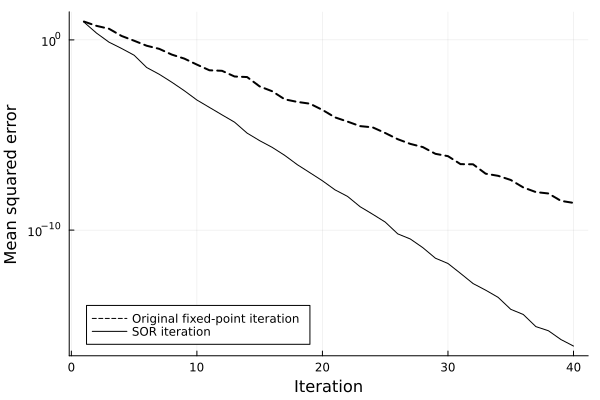

In [5]:
function fixed_point_itr(max_itr, b)
    x = zeros(n, K)
    for i in 1:max_itr
        x = A*x+b
    end
    return x
end

function SOR_itr(max_itr, b)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x + ωopt*(A*x+b - x)
    end
    return x
end

function comp_mse(max_itr, func)
    se = 0.0
    b, x_fixed = mini_batch(K)
    x̂ = func(max_itr, b)
    return norm(x̂ - x_fixed)^2/K
end
        
org_mse = [comp_mse(i, fixed_point_itr) for i in 1:num_itr];
SOR_mse = [comp_mse(i, SOR_itr) for i in 1:num_itr];

plot(1:num_itr, org_mse, lw=2, yscale=:log10, label="Original fixed-point iteration", color=:black, ls=:dash, xlabel="Iteration", ylabel="Mean squared error", legend=:bottomleft)
plot!(1:num_itr, SOR_mse, lw=1, label="SOR iteration", color=:black)

### DU-PSOR反復の定義 

In [6]:
function DU_PSOR(b, max_itr, ω, T)
    x = zeros(n, K)
    for i in 0:max_itr-1
        k = (i % T)+1 
        x = x + ω[k]*(A*x+b - x)
    end
    return x
end

DU_PSOR (generic function with 1 method)

### 損失関数の定義

In [7]:
function loss(x_fixed, x̂)
    return norm(x_fixed - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [8]:
function train(opt, ω, T)
    ps = Flux.params(ω)
    for itr in 1:train_depth
        for i in 1:max_inner 
            b, x_fixed = mini_batch(K)
            gs = Flux.gradient(ps) do
                x_hat = DU_PSOR(b, itr, ω, T)
                loss(x_fixed, x_hat)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        b, x_fixed = mini_batch(K)
        x̂ = DU_PSOR(b, itr, ω, T)
        println(loss(x_fixed, x̂))
    end
end

train (generic function with 1 method)

In [9]:
function comp_mse_DUPSOR(max_itr, ω, T)
    b, x_fixed = mini_batch(K)
    x̂ = DU_PSOR(b, max_itr, ω, T)
    return loss(x_fixed, x̂)
end

comp_mse_DUPSOR (generic function with 1 method)

### 学習過程

In [10]:
T = 2
ω_train = ones(T)
opt = Flux.ADAM(adam_lr)
train(opt, ω_train, T)

7.504138049096805
1.0184745124247474
0.2795406670787668
0.062407077536770134
0.015638055019806422
0.002783360584717569
0.0006755635469424806
0.00013474466897259518
3.023955761604132e-5
6.215041411149789e-6


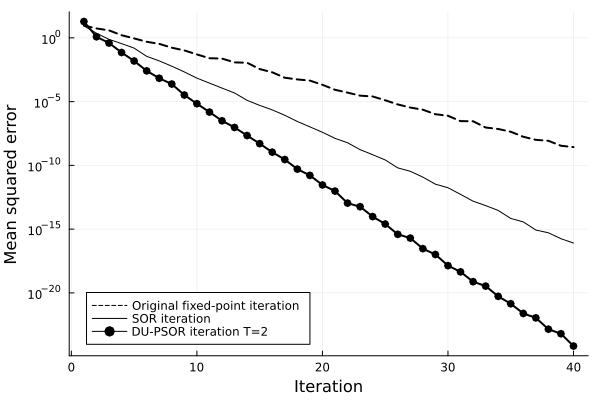

In [11]:
DUPSOR_mse =[comp_mse_DUPSOR(i, ω_train, T) for i in 1:num_itr]
plot!(1:num_itr, DUPSOR_mse, lw=2, label="DU-PSOR iteration T="*string(T), color=:black, marker=:o)

### 理論値の計算

In [12]:
function absβ(λ, ω, T)
    prod = 1.0
    for i in 1:T
        prod *= 1 - ω[i]*λ
    end
    return abs(prod)
end

absβ (generic function with 1 method)

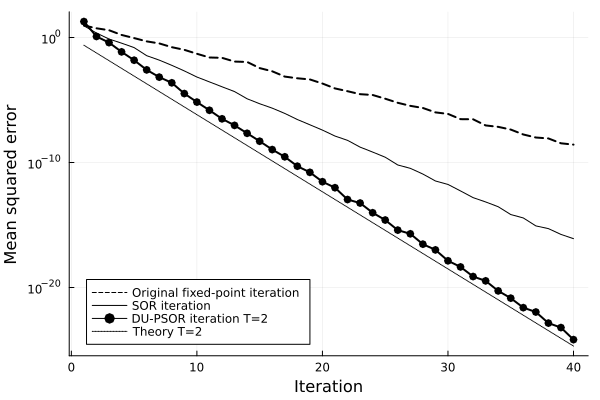

In [13]:
q = maximum(map(λ->absβ(λ,ω_train, T), eigvals(I-A)))^(2/T)
plot!(1:num_itr, t->q^t,lw=1, label="Theory T=2", ls=:dot, color=:black)

In [14]:
ωopt_T2 = ω_train

2-element Vector{Float64}:
 2.8119328406116093
 1.089404942355889

In [15]:
T = 4
ω_train = ones(T)
opt = Flux.ADAM(adam_lr)
train(opt, ω_train, T)

7.811608174764314
1.225961390855475
0.10098109994711532
0.014695151765045357
0.004801718625916657
0.00044809873723672953
4.628086450289233e-5
7.604699925557764e-6
6.181776096393104e-6
1.9455561304723324e-7


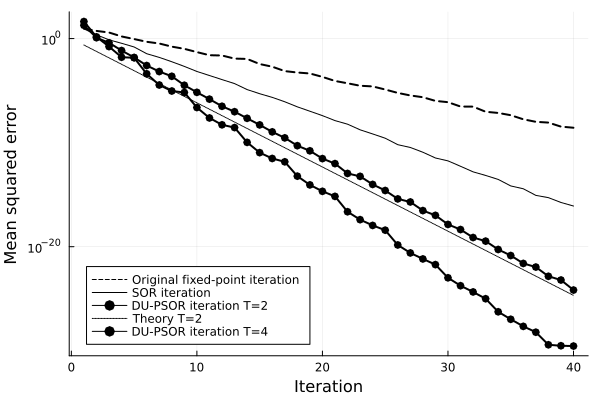

In [16]:
DUPSOR_mse =[comp_mse_DUPSOR(i, ω_train, T) for i in 1:num_itr]
plot!(1:num_itr, DUPSOR_mse, lw=2, label="DU-PSOR iteration T="*string(T), color=:black, marker=:o)

In [17]:
ωopt_T4 = ω_train

4-element Vector{Float64}:
 3.6653837470030894
 1.0300149009802693
 1.2921825119180372
 2.0167870492569273

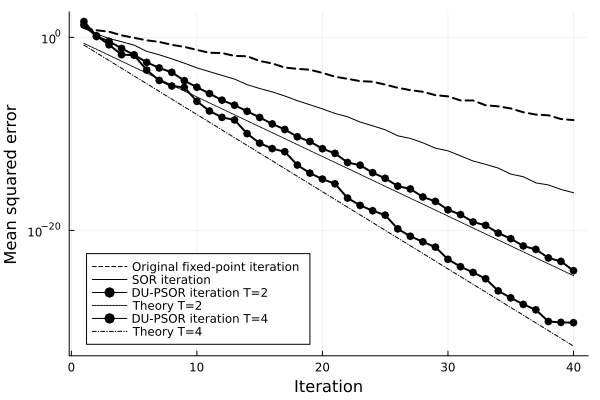

In [18]:
q = maximum(map(λ->absβ(λ,ω_train, T), eigvals(I-A)))^(2/T)
plot!(1:num_itr, t->q^t,lw=1, label="Theory T=4", color=:black, ls=:dashdot)

In [19]:
savefig("DU-PSOR.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_4/DU-PSOR.pdf"